## Simple Moving Average Strategy

Please note - this project is not trading/financial advice

This notebook shows a simple trading strategy using moving averages. This strategy is not expected to be better than a Buy and Hold strategy, but this was used as a project to revise moving averages before projects involving moving averages as features in models. Although my current research involves time series, we don’t typically consider moving averages, so I created this simple project to revised them from earlier in my education. 
 In this project stock data is imported from Yahoo Finance and we look at Manchester United PLC (MANU) data from 2017 onwards (we will also look at Google (GOOG) too). 
Using this data, we take 2 moving averages on the closing price of the previous days, a shorter and longer. Then build a strategy based on:

-	If the shorter average is greater than the longer average, there is an upward trend. This is because over the previous days the short-term average of the stock price is more than the long-term average.
-	If the longer average is greater than the shorter average, there is a downward trend. Likewise, this is because the longer-term average of the stock price is more than the short-term, indicating a decline in the stock value.

Moving averages are calculated as:

MA = (P<sub>1</sub> + P<sub>2</sub> + … + P<sub>n</sub>)/n

Where:
-	MA is the simple moving average
-	P is the price of the stock (in our case we use the closing price)
-	n is the number of days the average is calculated over 

### Import Required Modules

First we will import the required modules.

In [299]:
# for getting data
import pandas_datareader as pd_dr

# for data manipulation
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt

### Import the Data

Now we import the data from Yahoo Finance for Manchester United PLC (MANU), for this we use pandas_datareader. We also do some data processing to make things a little easier. 

Firstly, Yahoo Finance uses the date as an index in the DataFrame which can be a little annoying to use, therefore we create a ‘day’ column to make this a little easier. Secondly, we will mainly use the close price for building this strategy, so we will drop the adjusted close and volume columns. We will keep open, high and low just for completion and reorder the columns so that the DataFrame is a little more intuitive. Finally we call `stock_data.info()` for a quick check to ensure we don’t have any `NaN` values, we do not expect any but it is always good practice to check so we can deal with them if we do. 

In [396]:
# get data
stock_data = pd_dr.get_data_yahoo('MANU')

# drop unwanted columns
stock_data.drop(columns=['Adj Close', 'Volume'], inplace=True)

# add dates and set new index index
dates =[]
for i in range(len(stock_data)):
    newdate = str(stock_data.index[i])
    newdate = newdate[0:10]
    dates.append(newdate)
stock_data['dates'] = dates
index = np.arange(0, len(stock_data))
stock_data['index'] = index
stock_data.set_index('index',inplace=True)
stock_data.head()

# add days
days = np.arange(1, len(stock_data) + 1)
stock_data['day'] = days

# reorder columns
stock_data = stock_data[['dates', 'day', 'Open', 'High', 'Low', 'Close']]

# show DataFrame info and first rows
stock_data.info()
stock_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1257 entries, 0 to 1256
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   dates   1257 non-null   object 
 1   day     1257 non-null   int32  
 2   Open    1257 non-null   float64
 3   High    1257 non-null   float64
 4   Low     1257 non-null   float64
 5   Close   1257 non-null   float64
dtypes: float64(4), int32(1), object(1)
memory usage: 63.8+ KB


,dates,day,Open,High,Low,Close
index,,,,,,
0,2017-10-05,1,18.200001,18.350000,17.799999,18.100000
1,2017-10-06,2,18.049999,18.299999,18.000000,18.250000
2,2017-10-09,3,18.200001,18.250000,18.000000,18.000000
3,2017-10-10,4,17.950001,18.350000,17.950001,18.250000
4,2017-10-11,5,18.299999,18.299999,18.139999,18.299999


### Exploratory Data Analysis

We don’t do much exploratory data analysis here as we aren’t looking at any features other than the closing price. However, we can still plot out the closing price, mean and standard deviation over the 5 year period to give a sense of the stock volatility (I have left in some commented out code that would show how to calculate the standard deviation without using the built in NumPy function). 

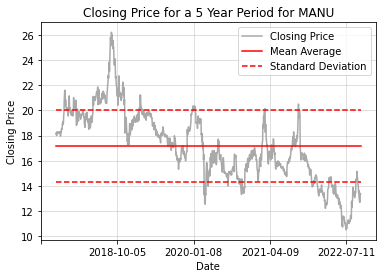

In [397]:
# volatility = pd.DataFrame(stock_data['Close'])
# volatility['daily_return'] = (volatility['Close']/ volatility['Close'].shift(1)) -1
# volatility['diff'] = volatility['Close'] - volatility['Close'].mean(axis=0)
# volatility['diff_sq'] = volatility['diff']**2
# sum = volatility['diff_sq'].sum() / len(volatility['diff_sq'])
# std = np.sqrt(sum)
# standard_dev = (np.std(volatility['Close']))
# print(standard_dev)

# define stats
mean = np.mean(stock_data['Close'])
std_min = mean - np.std(stock_data['Close'])
std_max = mean + np.std(stock_data['Close'])
date_array  = stock_data['dates']

# plot closing price with mean and std
fig, ax = plt.subplots()
plt.grid(True, alpha=0.5)
plt.plot(date_array, stock_data.iloc[-len(stock_data):]['Close'], c='darkgrey', label='Closing Price')
plt.plot((date_array[0], date_array[1256]), (mean, mean), c='r', label='Mean Average')
plt.plot((date_array[0], date_array[1256]), (std_min, std_min), c='r', linestyle='--', label='Standard Deviation')
plt.plot((date_array[0], date_array[1256]), (std_max, std_max), c='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing Price for a 5 Year Period for MANU')
plt.legend(loc='upper right')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 315))
plt.show()

As the moving average strategy is based on identifying trends in the stock data, we can see that there are many for the strategy to pick out, so we will go ahead and used this stock.

### Calculating the Moving Averages 

Now we calculate the moving averages over a 7 day (shorter) and 28 day (longer) period. We do this using the `rolling.mean()` function from pandas. We need to be careful not to use the current trading day in the moving average (this would be a look ahead if we did). Therefore, we use `.shift()` to ensure that use only use the days before. 

In [398]:
# get moving averages
stock_data['7-day'] = stock_data['Close'].rolling(7).mean().shift()
stock_data['28-day'] = stock_data['Close'].rolling(28).mean().shift()
stock_data[0:30]

,dates,day,Open,High,Low,Close,7-day,28-day
index,,,,,,,,
0,2017-10-05,1,18.200001,18.350000,17.799999,18.100000,NaN,NaN
1,2017-10-06,2,18.049999,18.299999,18.000000,18.250000,NaN,NaN
2,2017-10-09,3,18.200001,18.250000,18.000000,18.000000,NaN,NaN
3,2017-10-10,4,17.950001,18.350000,17.950001,18.250000,NaN,NaN
4,2017-10-11,5,18.299999,18.299999,18.139999,18.299999,NaN,NaN
5,2017-10-12,6,18.250000,18.299999,17.900000,18.250000,NaN,NaN
6,2017-10-13,7,18.299999,18.350000,18.150000,18.250000,NaN,NaN
7,2017-10-16,8,18.299999,18.299999,18.150000,18.200001,18.200000,NaN
8,2017-10-17,9,18.200001,18.299999,18.150000,18.200001,18.214286,NaN


By showing the first 30 rows we can see how the shift works. For the 7-day average, the first 7 days (index 0 to 6) are used to calculate the first average for the 8th day (index 7) will be our first entry. Without the shift the first day would be the 7th day (index 6) with the first 6 days AND the 7th day used to calculate the average (index 0 to 6). We can also see that any days before the first entries are `NaN` values, as we cannot calculate a 7-day average with less than 7 days (likewise for the 28-day).

Now we use the moving averages to create indicators ('signal') of the downward and upward trends in the stocks. This implements the strategy that was discussed at the start of the notebook.  Also, the `NaN` values are dropped from the DataFrame.

In [399]:
stock_data['signal'] = np.where(stock_data['7-day'] > stock_data['28-day'], 1, 0)
stock_data['signal'] = np.where(stock_data['7-day'] < stock_data['28-day'], -1, 0)
stock_data.dropna(inplace=True)
stock_data[0:30]

,dates,day,Open,High,Low,Close,7-day,28-day,signal
index,,,,,,,,,
28,2017-11-14,29,19.000000,19.350000,18.850000,19.100000,18.642857,18.310714,0
29,2017-11-15,30,18.900000,19.100000,18.799999,18.900000,18.764286,18.346429,0
30,2017-11-16,31,19.000000,19.879999,18.900000,19.000000,18.814286,18.369643,0
31,2017-11-17,32,18.900000,19.600000,18.900000,19.549999,18.885714,18.405357,0
32,2017-11-20,33,19.700001,19.850000,19.450001,19.750000,19.035714,18.451786,0
33,2017-11-21,34,19.799999,20.799999,19.799999,20.700001,19.185714,18.503571,0
34,2017-11-22,35,20.700001,21.400000,20.600000,21.150000,19.428571,18.591071,0
35,2017-11-24,36,21.350000,21.500000,21.200001,21.500000,19.735714,18.694643,0
36,2017-11-27,37,21.700001,21.750000,21.450001,21.600000,20.078571,18.812500,0


### Calculating Returns

Now returns are calculated to assess how well the strategy performed over the 5 year period. First we calculate returns for the standard buy and hold strategy (‘return’ column), then takes this return and multiply it by the signal to get the returns for the strategy (‘signal_return’). At this point we add an Entry column and here the difference in the signal column is recorded, this shows at which points the moving averages cross, so that when we plot out the stock we can see where our trend indicators plot and if they match the observed trends. 

In [400]:
stock_data['return'] = np.log(stock_data['Close']).diff()
stock_data['system_return'] = stock_data['signal'] * stock_data['return']
stock_data['entry'] = stock_data.signal.diff()
stock_data.head()

,dates,day,Open,High,Low,Close,7-day,28-day,signal,return,system_return,entry
index,,,,,,,,,,,,
28,2017-11-14,29,19.000000,19.350000,18.850000,19.100000,18.642857,18.310714,0,NaN,NaN,NaN
29,2017-11-15,30,18.900000,19.100000,18.799999,18.900000,18.764286,18.346429,0,-0.010526,-0.0,0.0
30,2017-11-16,31,19.000000,19.879999,18.900000,19.000000,18.814286,18.369643,0,0.005277,0.0,0.0
31,2017-11-17,32,18.900000,19.600000,18.900000,19.549999,18.885714,18.405357,0,0.028536,0.0,0.0
32,2017-11-20,33,19.700001,19.850000,19.450001,19.750000,19.035714,18.451786,0,0.010178,0.0,0.0


# Plotting Returns

Now the closing price and the 2 moving averages are plotted. We use the Entry column to plot our indicators (where the moving averages cross) with a red triangle for downward and a green triangle for upward.

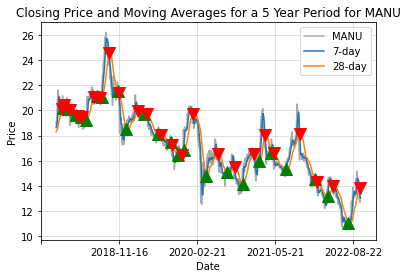

In [401]:
fig, ax = plt.subplots()
plt.grid(True, alpha=.5)
# plot data
plt.plot(date_array[-len(stock_data):], stock_data.iloc[-len(stock_data):]['Close'], label='MANU', c='darkgrey')
plt.plot(date_array[-len(stock_data):], stock_data.iloc[-len(stock_data):]['7-day'], label='7-day')
plt.plot(date_array[-len(stock_data):], stock_data.iloc[-len(stock_data):]['28-day'], label='28-day')
# plot indicators
plt.plot(stock_data[-len(stock_data):].loc[stock_data.entry == 1].dates, 
         stock_data[-len(stock_data):]['7-day'][stock_data.entry == 1],
         '^', color='g', markersize=12
        )
plt.plot(stock_data[-len(stock_data):].loc[stock_data.entry == -1].dates, 
         stock_data[-len(stock_data):]['28-day'][stock_data.entry == -1],
         'v', color='r', markersize=12
        )
# labels
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Closing Price and Moving Averages for a 5 Year Period for MANU')
plt.legend(loc='upper right')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 315))
plt.show()

Over the total 5 year period it is a little difficult to visually see if the indicators successfully found the trends in the closing price data, so we plot again but only for the last trading year (252 days).

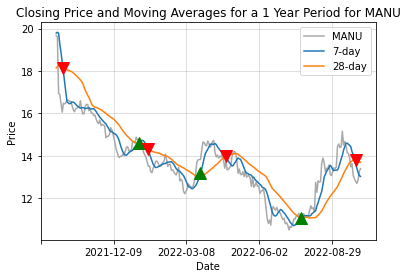

In [406]:
fig, ax = plt.subplots()
plt.grid(True, alpha=.5)
# plot data
plt.plot(date_array[-252:], stock_data.iloc[-252:]['Close'], label='MANU', c='darkgrey')
plt.plot(date_array[-252:], stock_data.iloc[-252:]['7-day'], label='7-day')
plt.plot(date_array[-252:], stock_data.iloc[-252:]['28-day'], label='28-day')
# plot indicators
plt.plot(stock_data[-252:].loc[stock_data.entry == 1].dates, 
         stock_data[-252:]['7-day'][stock_data.entry == 1],
         '^', color='g', markersize=12
        )
plt.plot(stock_data[-252:].loc[stock_data.entry == -1].dates, 
         stock_data[-252:]['28-day'][stock_data.entry == -1],
         'v', color='r', markersize=12
       )
# plot labels
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Closing Price and Moving Averages for a 1 Year Period for MANU')
plt.legend(loc='upper right')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 60))
plt.show()

In this graph we can see our indicators have done an okay job of picking out the trends in the closing price, certainly for the broader downward and upward trends. However, given we use the days before the calculate the moving average, this creates a lag in where these indicators plot against where the real trend starts. Furthermore, as we effectively smooth the data by averaging over the previous days, we cannot pick up the shorter-term trends. To gain a sense of how our simple strategy performed against the standard buy and hold strategy we now plot returns for both over the 5 year period.

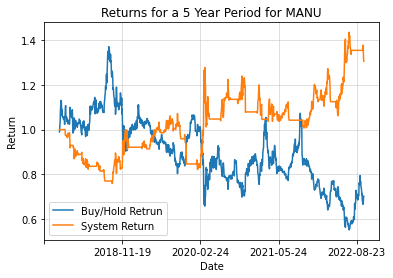

In [407]:
fig, ax = plt.subplots()
plt.grid(True, alpha=.5)
# plot returns
plt.plot(date_array[-len(stock_data):], np.exp(stock_data['return']).cumprod(), label='Buy/Hold Retrun')
plt.plot(date_array[-len(stock_data):], np.exp(stock_data['system_return']).cumprod(), label='System Return')
# labels
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Returns for a 5 Year Period for MANU')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 315))
plt.show()

We can see that our strategy has outperformed the buy and hold strategy, which is surprising. 

We can get the total buy and hold return percentage:

In [404]:
np.exp(stock_data['return']).cumprod()[-1:] -1

index
1256   -0.298429
Name: return, dtype: float64

And the system return percentage: 

In [405]:
np.exp(stock_data['system_return']).cumprod()[-1:] -1

index
1256    0.306648
Name: system_return, dtype: float64

This is a surprise our indicators did show some broad trends in the market, however they had a lag (due to the delay of averaging over a period) and they missed trends (due to a smoothing effect). However, this stock was perhaps a poor stock to pick, given that there is a large loss from using buy and hold. This is most likely due to this being a football stock, and therefore is influenced on many factors, other than economic, such as the teams performance or star signings within the football season. This may indicate that using the simple moving averages can return a positive investment (in this case a vergy good 30% return), but it doesn’t necessarily mean that it’s a good strategy (vs. buy and hold).

### Using a Classic Buy and Hold Stock

Let’s now rerun this strategy against a stock that we know performs well as a buy and hold stock, Google (GOOG). Here the code is largely the same, just condensed and the graphs are output for a year period along with the returns.

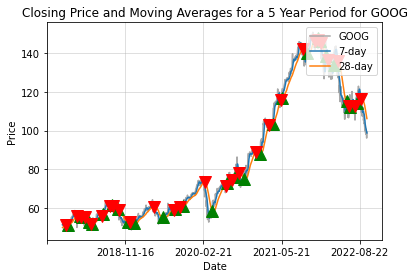

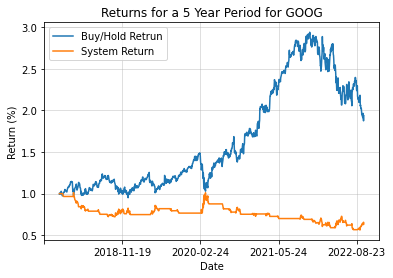

Buy/Hold:
index
1256    0.935673
Name: return, dtype: float64

System:
index
1256   -0.364375
Name: system_return, dtype: float64


In [395]:
stock_data = pd_dr.get_data_yahoo('GOOG')
stock_data.drop(columns=['Adj Close', 'Volume'], inplace=True)
dates =[]
for i in range(len(stock_data)):
    newdate = str(stock_data.index[i])
    newdate = newdate[0:10]
    dates.append(newdate)
stock_data['dates'] = dates
index = np.arange(0, len(stock_data))
stock_data['index'] = index
stock_data.set_index('index',inplace=True)
stock_data.head()
days = np.arange(1, len(stock_data) + 1)
stock_data['day'] = days
stock_data = stock_data[['dates', 'day', 'Open', 'High', 'Low', 'Close']]
stock_data['7-day'] = stock_data['Close'].rolling(7).mean().shift()
stock_data['28-day'] = stock_data['Close'].rolling(28).mean().shift()
stock_data['signal'] = np.where(stock_data['7-day'] > stock_data['28-day'], 1, 0)
stock_data['signal'] = np.where(stock_data['7-day'] < stock_data['28-day'], -1, 0)
stock_data.dropna(inplace=True)
stock_data['return'] = np.log(stock_data['Close']).diff()
#stock_data['return 2'] = (np.log(stock_data['Close'] / stock_data['Close'].shift(-1)))
stock_data['system_return'] = stock_data['signal'] * stock_data['return']
stock_data['entry'] = stock_data.signal.diff()
fig, ax = plt.subplots()
plt.grid(True, alpha=.5)
plt.plot(date_array[-len(stock_data):], stock_data.iloc[-len(stock_data):]['Close'], label='GOOG', c='darkgrey')
plt.plot(date_array[-len(stock_data):], stock_data.iloc[-len(stock_data):]['7-day'], label='7-day')
plt.plot(date_array[-len(stock_data):], stock_data.iloc[-len(stock_data):]['28-day'], label='28-day')
plt.plot(stock_data[-len(stock_data):].loc[stock_data.entry == 1].dates, 
         stock_data[-len(stock_data):]['7-day'][stock_data.entry == 1],
         '^', color='g', markersize=12
        )
plt.plot(stock_data[-len(stock_data):].loc[stock_data.entry == -1].dates, 
         stock_data[-len(stock_data):]['28-day'][stock_data.entry == -1],
         'v', color='r', markersize=12
        )
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Closing Price and Moving Averages for a 5 Year Period for GOOG')
plt.legend(loc='upper right')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 315))
plt.show()
fig, ax = plt.subplots()
plt.grid(True, alpha=.5)
plt.plot(date_array[-len(stock_data):], np.exp(stock_data['return']).cumprod(), label='Buy/Hold Retrun')
plt.plot(date_array[-len(stock_data):], np.exp(stock_data['system_return']).cumprod(), label='System Return')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.title('Returns for a 5 Year Period for GOOG')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 315))
plt.show()
print('Buy/Hold:')
print(np.exp(stock_data['return']).cumprod()[-1:] -1)
print()
print('System:')
print(np.exp(stock_data['system_return']).cumprod()[-1:] -1)

We can see now when we use this strategy against a stock that performs well over time, almost a double in returns for buy and hold over 5 years, the simple moving average strategy performs poorly (losing around 35%). We can see from the indicators we try and spot the trends but due to the market we tend to trade in the opposite direction, resulting in the loss. We could try and use different periods for the moving averages (longer or shorter), but in this case this simple strategy is significantly outperformed by buy and hold. 